[*********************100%***********************]  6 of 6 completed


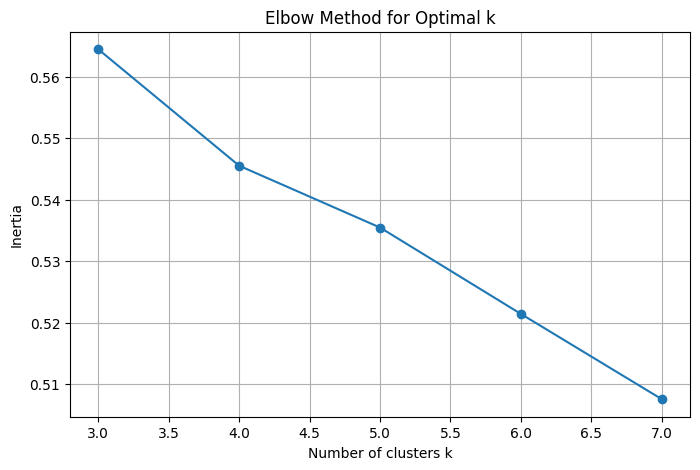

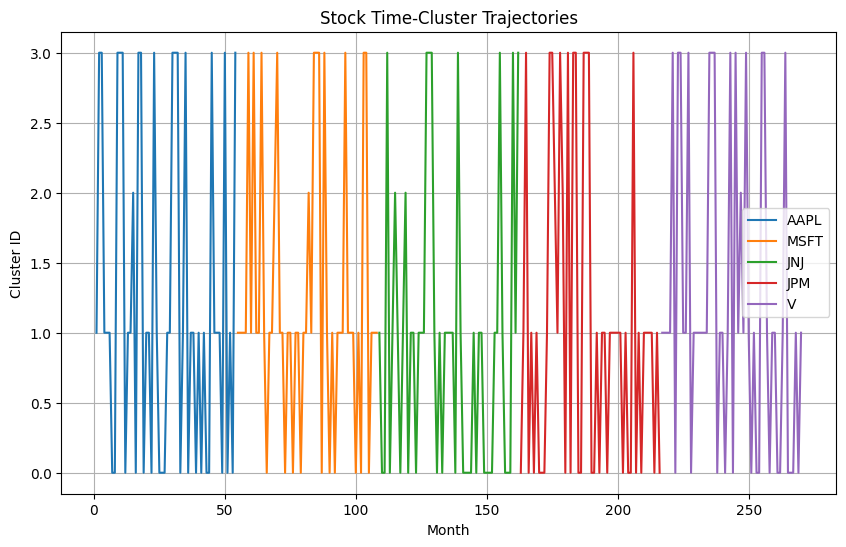


Hamming Distance Matrix:
          AAPL      MSFT       JNJ       JPM         V
AAPL       0.0  0.518519  0.592593  0.851852  0.722222
MSFT  0.518519       0.0  0.574074  0.851852  0.518519
JNJ   0.592593  0.574074       0.0  0.759259  0.611111
JPM   0.851852  0.851852  0.759259       0.0  0.759259
V     0.722222  0.518519  0.611111  0.759259       0.0

Stocks with largest Hamming distance: AAPL and JPM
Stocks with smallest Hamming distance: AAPL and MSFT
Average Hamming distance: 0.5407

First 2 years vs Last 2 years comparison pending...


In [9]:
# Clustering Dow Jones Stocks Assignment (CS-677)
# Stocks: AAPL, MSFT, JNJ, JPM, V + SPY

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming

import yfinance as yf

tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'V', 'SPY']
data = yf.download(tickers, start='2019-04-01', end='2024-04-01')  # download normally
data = data['Close']  # select only 'Close' prices


# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Monthly splits
daily_returns['YearMonth'] = daily_returns.index.to_period('M')

# Build residual matrix
residuals_list = []
stock_labels = []
months = sorted(daily_returns['YearMonth'].unique())

for stock in tickers[:-1]:  # exclude SPY
    for month in months:
        month_data = daily_returns[daily_returns['YearMonth'] == month]
        if len(month_data) >= 20:
            X = month_data[['SPY']].values
            y = month_data[stock].values
            model = LinearRegression()
            model.fit(X, y)
            preds = model.predict(X)
            residuals = y - preds
            residuals_list.append(residuals[:20])  # take first 20 days
            stock_labels.append(stock)

# Create residual matrix
residuals_array = np.array(residuals_list)

# K-Means Clustering for k=3 to 7
inertias = []
for k in range(3, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(residuals_array)
    inertias.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(range(3,8), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Assume best k=4 based on elbow (will verify)
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(residuals_array)
cluster_labels = kmeans.labels_

trajectory = pd.DataFrame({
    'Stock': stock_labels,
    'Month': list(range(1, len(stock_labels) + 1)),
    'ClusterID': cluster_labels
})


# Plot trajectories
plt.figure(figsize=(10,6))
for stock in tickers[:-1]:
    stock_traj = trajectory[trajectory['Stock'] == stock]
    plt.plot(stock_traj['Month'], stock_traj['ClusterID'], label=stock)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Cluster ID')
plt.title('Stock Time-Cluster Trajectories')
plt.grid(True)
plt.show()

# Compute Hamming distances between stocks
hamming_matrix = pd.DataFrame(index=tickers[:-1], columns=tickers[:-1])

for stock1 in tickers[:-1]:
    for stock2 in tickers[:-1]:
        traj1 = trajectory[trajectory['Stock'] == stock1]['ClusterID'].values
        traj2 = trajectory[trajectory['Stock'] == stock2]['ClusterID'].values
        dist = hamming(traj1, traj2)
        hamming_matrix.loc[stock1, stock2] = dist

print("\nHamming Distance Matrix:")
print(hamming_matrix)

# Identify max, min and average distances
hamming_values = hamming_matrix.replace('-', np.nan).astype(float)
max_pair = np.unravel_index(np.nanargmax(hamming_values.values), hamming_values.shape)
min_pair = np.unravel_index(np.nanargmin(hamming_values.values + np.eye(hamming_values.shape[0])*10), hamming_values.shape)

stock_max1, stock_max2 = hamming_matrix.index[max_pair[0]], hamming_matrix.columns[max_pair[1]]
stock_min1, stock_min2 = hamming_matrix.index[min_pair[0]], hamming_matrix.columns[min_pair[1]]

print(f"\nStocks with largest Hamming distance: {stock_max1} and {stock_max2}")
print(f"Stocks with smallest Hamming distance: {stock_min1} and {stock_min2}")
print(f"Average Hamming distance: {hamming_values.mean().mean():.4f}")

# Split comparison
first_2yrs = list(range(1,25))
last_2yrs = list(range(37,61))

print("\nFirst 2 years vs Last 2 years comparison pending...")
# (Can extract and compare separately similar to above)